In [1]:
# Training script for LazyConfig models
try:
    # ignore ShapelyDeprecationWarning from fvcore
    import warnings

    from shapely.errors import ShapelyDeprecationWarning

    warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

except:
    pass
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Some basic setup:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger

setup_logger()

import gc
import os
import time

import detectron2.utils.comm as comm

# import some common libraries
import numpy as np
import torch

# import some common detectron2 utilities
from detectron2.config import LazyConfig, get_cfg
import detectron2.data as data
from detectron2.engine import (
    launch,
)

from deepdisc.data_format.augment_image import train_augs
from deepdisc.data_format.image_readers import DC2ImageReader
from deepdisc.data_format.register_data import (
    register_data_set,
)  # , register_loaded_data_set
from deepdisc.model.loaders import (
    RedshiftFlatDictMapper,
    return_test_loader,
    return_train_loader,
)
from deepdisc.model.models import (
    RedshiftPointCasROIHeads,
    RedshiftPointROIHeads,
    RedshiftPDFROIHeads,
    return_lazy_model,
)
from deepdisc.training.trainers import (
    return_evallosshook,
    return_lazy_trainer,
    return_optimizer,
    return_savehook,
    return_schedulerhook,
)
from deepdisc.utils.parse_arguments import make_training_arg_parser

In [2]:
# import importlib
# importlib.reload(rail.estimation.algos.deepdisc)

In [3]:
# from rail.estimation.algos.deepdisc import DeepDiscInformer
import rail
from rail.estimation.algos.deepdisc import *
from rail.core.data import TableHandle, JsonHandle
from rail.core.stage import RailStage

from rail.deepdisc.configs import *

In [4]:
#/home/shared/hsc/DC2/test_data/dataset_3/flattened_images_train_small.npy
cfgfile = "/home/shared/hsc/detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.py"
dirpath = "./tests/deepdisc/test_data/dc2/"
output_dir = "./"
output_name = "test"

#trainfile = dirpath + "flattened_data_test.npy"
trainfile = "/home/shared/hsc/DC2/test_data/dataset_3/flattened_images_train.hdf5"
testfile = "/home/shared/hsc/DC2/test_data/dataset_3/flattened_images_test.hdf5"
metadatafile = "/home/shared/hsc/DC2/test_data/dataset_3/train_metadata.json"
test_metadatafile = "/home/shared/hsc/DC2/test_data/dataset_3/test_metadata.json"

classes = ["object"]
numclasses = 1

In [5]:
cfg = get_lazy_config(cfgfile, 1, 1)
cfg.train.init_checkpoint

'detectron2://ImageNetPretrained/MSRA/R-50.pkl'

In [6]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

In [7]:
from deepdisc.data_format.file_io import get_data_from_json

#testdata = np.load(trainfile, allow_pickle=True)
#testdata = DS.read_file("testdata", TableHandle, trainfile)
metadata = get_data_from_json(metadatafile)
test_metadata = get_data_from_json(test_metadatafile)

In [8]:
#training = DS.add_data("training", testdata(), TableHandle, path=trainfile) #()["images"]
#testing = DS.add_data("testing", testdata, TableHandle)

training = DS.add_data("training", data=None, handle_class=TableHandle, path=trainfile) #()["images"]
testing = DS.add_data("testing", data=None, handle_class=TableHandle, path=testfile)

metadatahandle = DS.add_data("metadata", metadata, JsonHandle, path=metadatafile)
#metadatahandle = DS.add_data("test_metadata", test_metadata, JsonHandle, path=test_metadatafile)

In [12]:
deep_dict = dict(
    chunk_size=100,
    epochs=20,
    numclasses=1,
    batch_size=4,
    output_dir="./",
    cfgfile="/home/shared/hsc/detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.py",
    output_name="test_informer",
    num_gpus=1,
    period = 5
#     hdf5_groupname="images",
    
)

In [13]:
# Inform = DeepDiscInformer.make_stage(name='Inform_DeepDISC', model='detectron2://ImageNetPretrained/MSRA/R-50.pkl', **deep_dict)
Inform = DeepDiscInformer.make_stage(
    name="Inform_DeepDISC", model="test_informer.pkl", **deep_dict
)

In [14]:
Inform.inform(training, metadatahandle)

caching data
Training head layers
[12/07 21:10:30 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/07 21:10:30 d2.data.common]: Serializing 1000 elements to byte tensors and concatenating them all ...
[12/07 21:11:01 d2.data.common]: Serialized dataset takes 274.77 MiB
[12/07 21:11:01 d2.data.build]: Making batched data loader with batch_size=4
[12/07 21:11:04 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from None ...
[12/07 21:11:04 d2.engine.train_loop]: Starting training from iteration 0
Iteration:  5  time:  5.059409886598587e-07 dict_keys(['loss_cls', 'loss_box_reg', 'loss_mask', 'redshift_loss', 'loss_rpn_cls', 'loss_rpn_loc']) [11.090518951416016, 2.0221240520477295, 0.7098885774612427, 1.1774752140045166, 0.7628128528594971, 2.343175172805786] val loss:  0 lr:  [0.001]
Iteration:  10  time:  6.631016731262207e-07 dict_keys(['loss_cls', 'loss_box_reg', 'loss_mask', 'redshift_loss', 'loss_rpn_cls', '

### Inference

In [15]:
metadatahandle = DS.add_data("metadata", test_metadata, JsonHandle, path=test_metadatafile)

In [16]:
# Estimator = DeepDiscEstimator.make_stage(name='DeepDiscEstimator',
#                                       model=Inform.get_handle('model'), **deep_dict)

Estimator = DeepDiscPDFEstimator.make_stage(
    name="DeepDiscEstimator",
    model=Inform.get_handle("model"),
    #hdf5_groupname="images",
    **deep_dict,
)

In [17]:
results = Estimator.estimate(testing, metadatahandle)

caching data
[12/07 20:54:35 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./test_informer.pth ...
Processing Data
Matching objects
Inserting handle into data store.  output_DeepDiscEstimator: inprogress_output_DeepDiscEstimator.hdf5, DeepDiscEstimator
Inserting handle into data store.  truth_DeepDiscEstimator: inprogress_truth_DeepDiscEstimator, DeepDiscEstimator


In [18]:
res = results.read()
res

In [19]:
truth = Estimator.get_handle('truth')


In [20]:
ztrue = truth.data['redshift']

In [21]:
from rail.evaluation.evaluator import Evaluator

In [22]:
deep_eval_dict = dict(
    chunk_size=100,
    zmin=-1,
    zmax=5,
    nzbins=200,
    epochs=20,
    output_name="test_evaluator",
    point_metrics=''
    
)

In [23]:
DeepEvaluator = Evaluator.make_stage(name="DeepDiscEvaluator",**deep_eval_dict)

In [24]:
eval_res = DeepEvaluator.evaluate(res,truth)

Inserting handle into data store.  input: None, DeepDiscEvaluator
Inserting handle into data store.  output_DeepDiscEvaluator: inprogress_output_DeepDiscEvaluator.hdf5, DeepDiscEvaluator


In [25]:
eval_res.data

{'PIT_AD_stat': array([-0.67968386]),
 'PIT_AD_pval': array([nan]),
 'PIT_AD_significance_level': array([0.25]),
 'PIT_CvM_stat': array([0.14184181]),
 'PIT_CvM_pval': array([nan]),
 'PIT_CvM_significance_level': array([nan]),
 'PIT_KS_stat': array([0.07052639]),
 'PIT_KS_pval': array([nan]),
 'PIT_KS_significance_level': array([nan]),
 'PIT_OutRate_stat': array([nan]),
 'PIT_OutRate_pval': array([nan]),
 'PIT_OutRate_significance_level': array([nan]),
 'CDE_stat': array([-0.41937158]),
 'CDE_pval': array([nan])}

In [26]:
from qp.metrics.pit import PIT
from utils import * #plot_pit_qq, ks_plot
pitobj = PIT(res, ztrue)
pit_out_rate = pitobj.evaluate_PIT_outlier_rate()

In [27]:
from qp.ensemble import Ensemble

class Sample(Ensemble):
    """ Expand qp.Ensemble to append true redshifts
    array, metadata, and specific plots. """

    def __init__(self, pdfs, zgrid, ztrue, photoz_mode=None, code="", name="", n_quant=100):
        """Class constructor

        Parameters
        ----------
        pdfs: `ndarray`
            photo-z PDFs array, shape=(Ngals, Nbins)
        zgrid: `ndarray`
            PDF bins centers, shape=(Nbins,)
        ztrue: `ndarray`
            true redshifts, shape=(Ngals,)
        photoz_mode: `ndarray`
            photo-z (PDF mode), shape=(Ngals,)
        code: `str`, (optional)
            algorithm name (for plot legends)
        name: `str`, (optional)
            sample name (for plot legends)
        """

        super().__init__(interp, data=dict(xvals=zgrid, yvals=pdfs))
        self._pdfs = pdfs
        self._zgrid = zgrid
        self._ztrue = ztrue
        self._photoz_mode = photoz_mode
        self._code = code
        self._name = name
        self._n_quant = n_quant
        self._pit = None
        self._qq = None


    @property
    def code(self):
        """Photo-z code/algorithm name"""
        return self._code

    @property
    def name(self):
        """Sample name"""
        return self._name

    @property
    def ztrue(self):
        """True redshifts array"""
        return self._ztrue

    @property
    def zgrid(self):
        """Redshift grid (binning)"""
        return self._zgrid

    @property
    def photoz_mode(self):
        """Photo-z (mode) array"""
        return self._photoz_mode

    @property
    def n_quant(self):
        return self._n_quant

    @property
    def pit(self):
        if self._pit is None:
            pit_array = np.array([self[i].cdf(self.ztrue[i])[0][0] for i in range(len(self))])
            self._pit = pit_array
        return self._pit

    @property
    def qq(self, n_quant=100):
        q_theory = np.linspace(0., 1., n_quant)
        q_data = np.quantile(self.pit, q_theory)
        self._qq = (q_theory, q_data)
        return self._qq

    def __len__(self):
        if len(self._ztrue) != len(self._pdfs):
            raise ValueError("Number of pdfs and true redshifts do not match!!!")
        return len(self._ztrue)

    def __str__(self):
        code_str = f'Algorithm: {self._code}'
        name_str = f'Sample: {self._name}'
        line_str = '-' * (max(len(code_str), len(name_str)))
        text = str(line_str + '\n' +
                   name_str + '\n' +
                   code_str + '\n' +
                   line_str + '\n' +
                   f'{len(self)} PDFs with {len(self.zgrid)} probabilities each \n' +
                   f'qp representation: {self.gen_class.name} \n' +
                   f'z grid: {len(self.zgrid)} z values from {np.min(self.zgrid)} to {np.max(self.zgrid)} inclusive')
        return text

    def plot_pdfs(self, gals, show_ztrue=True, show_photoz_mode=False):
        colors = plot_pdfs(self, gals, show_ztrue=show_ztrue,
                                 show_photoz_mode=show_photoz_mode)
        return colors

    def plot_old_valid(self, gals=None, colors=None):
        old_metrics_table = plot_old_valid(self, gals=gals, colors=colors)
        return old_metrics_table

    def plot_pit_qq(self, bins=None, label=None, title=None, show_pit=True,
                    show_qq=True, show_pit_out_rate=True, savefig=False):
        """Make plot PIT-QQ as Figure 2 from Schmidt et al. 2020."""
        fig_filename = plot_pit_qq(self, bins=bins, label=label, title=title,
                                         show_pit=show_pit, show_qq=show_qq,
                                         show_pit_out_rate=show_pit_out_rate,
                                         savefig=savefig)
        return fig_filename

In [28]:
def plot_pit_qq(pdfs, zgrid, ztrue, bins=None, title=None, code=None,
                show_pit=True, show_qq=True,
                pit_out_rate=None, savefig=False) -> str:
    """Quantile-quantile plot
    Ancillary function to be used by class Metrics.
​
    Parameters
    ----------
    pit: `PIT` object
        class from metrics.py
    bins: `int`, optional
        number of PIT bins
        if None, use the same number of quantiles (sample.n_quant)
    title: `str`, optional
        if None, use formatted sample's name (sample.name)
    label: `str`, optional
        if None, use formatted code's name (sample.code)
    show_pit: `bool`, optional
        include PIT histogram (default=True)
    show_qq: `bool`, optional
        include QQ plot (default=True)
    pit_out_rate: `ndarray`, optional
        print metric value on the plot panel (default=None)
    savefig: `bool`, optional
        save plot in .png file (default=False)
    """

    if bins is None:
        bins = 100
    if title is None:
        title = ""

    if code is None:
        code = ""
        label = ""
    else:
        label = code + "\n"

    if pit_out_rate is not None:
        try:
            label += "PIT$_{out}$: "
            label += f"{float(pit_out_rate):.4f}"
        except:
            print("Unsupported format for pit_out_rate.")

    plt.figure(figsize=[4, 5])
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    ax0 = plt.subplot(gs[0])
    sample = Sample(pdfs, zgrid, ztrue)

    if show_qq:
        ax0.plot(sample.qq[0], sample.qq[1], c='r',
                 linestyle='-', linewidth=3, label=label)
        ax0.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=2)
        ax0.set_ylabel("Q$_{data}$", fontsize=18)
        plt.ylim(-0.001, 1.001)
    plt.xlim(-0.001, 1.001)
    plt.title(title)
    if show_pit:
        fzdata = Ensemble(interp, data=dict(xvals=zgrid, yvals=pdfs))
        pitobj = PIT(fzdata, ztrue)
        pit_vals = np.array(pitobj.pit_samps)
        pit_out_rate = pitobj.evaluate_PIT_outlier_rate()
        
        try:
            y_uni = float(len(pit_vals)) / float(bins)
        except:
            y_uni = float(len(pit_vals)) / float(len(bins))
        if not show_qq:
            ax0.hist(pit_vals, bins=bins, alpha=0.7, label=label)
            ax0.set_ylabel('Number')
            ax0.hlines(y_uni, xmin=0, xmax=1, color='k')
            plt.ylim(0, )  # -0.001, 1.001)
        else:
            ax1 = ax0.twinx()
            ax1.hist(pit_vals, bins=bins, alpha=0.7)
            ax1.set_ylabel('Number')
            ax1.hlines(y_uni, xmin=0, xmax=1, color='k')
    leg = ax0.legend(handlelength=0, handletextpad=0, fancybox=True)
    for item in leg.legendHandles:
        item.set_visible(False)
    if show_qq:
        ax2 = plt.subplot(gs[1])
        ax2.plot(sample.qq[0], (sample.qq[1] - sample.qq[0]), c='r', linestyle='-', linewidth=3)
        plt.ylabel("$\Delta$Q", fontsize=18)
        ax2.plot([0, 1], [0, 0], color='k', linestyle='--', linewidth=2)
        plt.xlim(-0.001, 1.001)
        plt.ylim(np.min([-0.12, np.min(sample.qq[1] - sample.qq[0]) * 1.05]),
                 np.max([0.12, np.max(sample.qq[1] - sample.qq[0]) * 1.05]))
    if show_pit:
        if show_qq:
            plt.xlabel("Q$_{theory}$ / PIT Value", fontsize=18)
        else:
            plt.xlabel("PIT Value", fontsize=18)
    else:
        if show_qq:
            plt.xlabel("Q$_{theory}$", fontsize=18)
    if savefig:
        fig_filename = str("plot_pit_qq_" +
                           f"{(code).replace(' ', '_')}.png")
        plt.savefig(fig_filename)
    else:
        fig_filename = None

    return fig_filename

/tmp/ipykernel_2957635/663945040.py:80: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in leg.legendHandles:


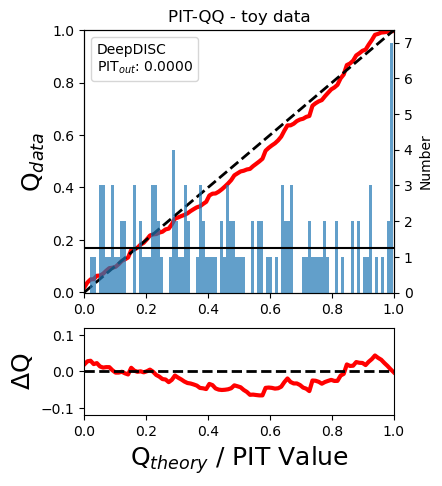

In [29]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from qp import interp


zgrid = np.linspace(-1,5,200)
pdfs = res.objdata()['yvals']
plot_pit_qq(pdfs, zgrid, ztrue, title="PIT-QQ - toy data", code="DeepDISC",
                pit_out_rate=pit_out_rate, savefig=False)

In [37]:
res.objdata()

{'yvals': array([[3.89700344e-02, 4.19601453e-02, 4.51285204e-02, ...,
         2.62053991e-05, 2.25728506e-05, 1.94218223e-05],
        [3.89700344e-02, 4.19601453e-02, 4.51285204e-02, ...,
         2.62053991e-05, 2.25728506e-05, 1.94218223e-05],
        [4.14258100e-02, 4.44458326e-02, 4.76352519e-02, ...,
         5.07430591e-05, 4.41358503e-05, 3.83480852e-05],
        ...,
        [3.88002224e-02, 4.17888388e-02, 4.49564409e-02, ...,
         2.48184959e-05, 2.13613429e-05, 1.83648215e-05],
        [4.00282984e-02, 4.30368549e-02, 4.62204005e-02, ...,
         3.40303269e-05, 2.94265929e-05, 2.54175329e-05],
        [3.91841442e-02, 4.22347601e-02, 4.54700312e-02, ...,
         1.84646055e-05, 1.58307403e-05, 1.35568366e-05]])}